## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to< plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

C:\Users\edson\anaconda3\Lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\edson\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\edson\anaconda3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
To

## Using GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda') # GPU will be used if available
elif torch.backends.mps.is_available():
    device = torch.device('mps') # GPU will be used in Apple Silicon Macs if available
else:
    device = torch.device('cpu') # CPU will be used if GPU is not available
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [ ]:
"""
Train and Test sets are created with data of the AG_NEWS

"""

train_dataset, test_dataset = AG_NEWS() #Loads the AG_NEWS dataset into train and test sets
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset) #Here we converts the datasets to a dict format

C:\Users\edson\anaconda3\Lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [ ]:
"""
yield_tokens function iterates through the dataset and generate tokenized text
using the tokenizer
"""


# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [ ]:
"""
build_vocab_from_iterator buils a vocavulary from the training data tokens,
also the special "<unk>" token from unknown words set at index 0
"""

# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [ ]:
"""
Here we test the tokenization
"""

#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [ ]:
"""
NUM_TRAIN and NUM_VAL contains the number of samples for train and validation
"""

NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [ ]:
"""
Then we splits dataset into traning dataset into training and validation sets 
with the privous NUM_TRAIN and NUM_VAL
"""

train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset)) #Prints the lengths of the training, validation, and test datasets

108000 12000 7600


In [ ]:
"""
collate_batch:

Takes a batch of data as imput
Extracts labels y and text x from the batch
Texts get tokenized using tokeniser and then its converted to numerical indices using vocab
Then sequences are truncated to a fixed length (max_tonekns)

Returns athe tokenized sequence and labels to pytorch tensors
"""

# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch)) #
     
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [ ]:
labels =  ["World", "Sports", "Business", "Sci/Tech"] #List of classes / labels
max_tokens = 50 #Max length on sequences
BATCH_SIZE = 256 #Batch size

In [ ]:
"""
Each loaders are created with the sets train, val and test
Here we use collate_batch to process batches
"""

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True) #
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [ ]:
"""
Constants the will define the model to use
"""

EMBEDDING_SIZE = 64  #maps words to dense vectors
NEURONS = 64  #Number of neurons of the fc layer
LAYERS = 2  #Number of LSTM layers stack one behind other
NUM_CLASSES = 4 #Quantity of outputs

In [ ]:
"""
The core unit used to processes the tokenized text is a LSTM architecture
LSTM model receive tokens and then computes throught a fc layer to generate 4 outputs for each class
"""


class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),  # this is the size of the dictionary of embeddings
                                            embedding_dim=embed_size) # this is the size of each embedding vector
        
        self.rnn = nn.LSTM(embed_size, hidden, layers, batch_first=True)    #the embed vector is received and proces 2 times as  
                                                                            #defined before on the layers, batch_firts indicates that the tensor has the 
                                                                            #length of the batch on the first position of the tensor
       
        
        self.fc = nn.Linear(hidden, num_classes)    # Here we use a FC layer to processes the data to get the outputs 
                                                    # num_classes is the 4 clases to predict "World", "Sports", "Business", "Sci/Tech"
        
    
    def forward(self, x): #The input to the module is a list of indices
        x = self.embedding_layer(x) #The output is the corresponding word embeddings
        output, (x , _) = self.rnn(x) #x is a vector of the hidden states computed from the LSTM cell (or cells)
        x = x[-1,:,:] # the final hidden stated is extracted
        x = self.fc(x) # the output 
        return x
        

In [ ]:
def accuracy(model, loader):
    correctos = 0 #number of correct outputs that correspont to the true labels
    total = 0 #total of correct outputs generated on the full batch
    model.eval() # This function set the model on evaluation, then it will not compute the gradiants of the parameters
    model = model.to(device=device) # The model is charged on the device, on the gpu
    with torch.no_grad():
        for x_batch, y_batch in loader: 
            #The batched data are charged to the gpu
            x_batch, y_batch = x_batch.to(device=device, dtype=torch.int),y_batch.to(device=device, dtype=torch.long)

            resultados = model(x_batch) #the model processes and returns the predicted outputs
            
            _, predicciones = resultados.max(dim=1)  #pred shape 
            # the predicted labels are compared with the true labels and get summed all the right answers
            correctos += (predicciones == y_batch).sum()  
            total += predicciones.size(0) 

    accuracy = 100 * correctos / total
    return accuracy

In [ ]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device) #the model is charged on the gpu
    for epoch in range(epochs): #the model is going to loop on the range of number of epochs
        
        for i, (x_batch,y_batch) in enumerate(train_loader):
            model.train() #the model is set on train mode
            
            #the data are charged on the gpu to be computed
            x_batch, y_batch = x_batch.to(device, dtype=torch.int), y_batch.to(device, dtype=torch.long)
    
            #model processes the data and the output is saved on the resultados variable
            resultados = model(x_batch)
            #loss is calculated with cross entropy because we are looking throught many labels
            loss = F.cross_entropy(input= resultados, target=y_batch) 

            optimiser.zero_grad() #optimiser is cleaned 
            loss.backward() #loss calculates the gradiants to uptdate the weights 
            optimiser.step() #weights are updated

            acc = accuracy(model, val_loader)  # accuracy is called to find how correct the model is with the val set
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Acc: {acc}")

In [ ]:
"""
We set the number of epochs for the train
lr indicates the change to reduce the loss of the model
"""

epochs = 3
lr = 0.01


# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES) #
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [21]:
print(rnn_model)

RNN_Model_1(
  (embedding_layer): Embedding(95811, 64)
  (rnn): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [22]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch [1/3], Loss: 0.3238, Acc: 90.1500015258789
Epoch [2/3], Loss: 0.1362, Acc: 91.61666870117188
Epoch [3/3], Loss: 0.1358, Acc: 91.25833129882812


In [23]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

91.4079


In [ ]:
"""
sample_text
samples a batch of data from the test loader
makes a prediction on the data 
and then the original text, true label, and the predicted label for each sample is printed
the print is stopped when a <pad> is found or when the second batch is gotten

"""

def sample_text(model, loader):
    model.eval() #model is set on eval mode
    samples=[] #this list saves the samples taken
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(loader): #the test loader is iterated
            
            if (i == 1):
                break #when the loop gets to the second batch is gotten
          
            # the data is loaded in the gpu
            x_batch, y_batch = x_batch.to(device=device, dtype=torch.int),y_batch.to(device=device, dtype=torch.long)
            resultados = model(x_batch) #the model processes the data
            _, predicciones = resultados.max(dim=1)  #the predictions are taken from the fist dimension to the output tensor
    
            for j in range(len(x_batch)): #the original text tokenized is iterated
                texto_tokens = vocab.lookup_tokens(x_batch[j].cpu().numpy()) #each number tokenized that represents a word return to be a word
                if texto_tokens == '<pad>': #when the restored word is <pad> then the print and all is stopped 
                    break
                texto_original = ' '.join(texto_tokens) #all the returned words are joinned
                prediccion = labels[predicciones[j]] #the prediction is taken from predicciones 
                real = labels[y_batch[j]] #the true label is taken

        samples.append((texto_original,real,prediccion))
    print('muestras de prediccion: ')
    for texto, real, prediccion in samples:
        print(f"Texto: {texto}\nEtiqueta Real: {real} - Etiqueta Predicha: {prediccion}\n")



In [25]:
sample_text(rnn_model, test_loader)

muestras de prediccion: 
Texto: microsoft ends decade of antitrust suits seattle/new york ( reuters ) - microsoft corp . &lt a href=http //www . investor . reuters . com/fullquote . aspx ? ticker=msft . o target=/stocks/quickinfo/fullquote&gt msft . o&lt /a&gt said on monday it had agreed to settle antitrust lawsuits with novell inc .
Etiqueta Real: Business - Etiqueta Predicha: Business



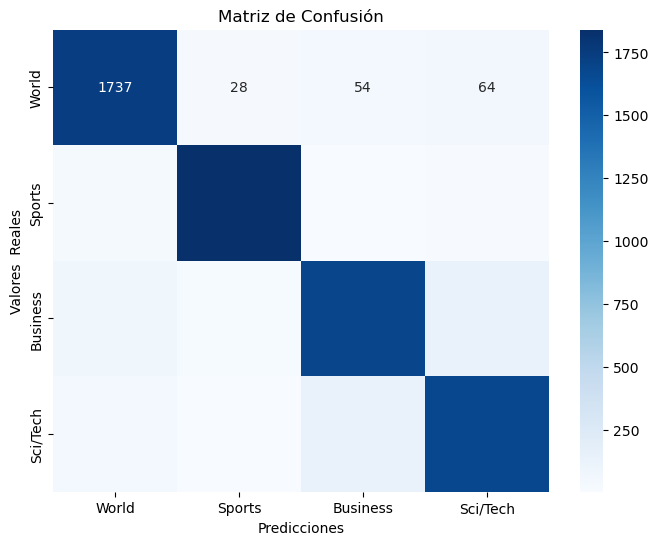

In [ ]:

"""
plot_confusion_matrix:

Calculates the confusion matrix on the test set
Visualizes the confusion matrix using a heatmap

"""

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, labels):
    model.eval() #sets the model to evaluation mode
    model = model.to(device) #the model is sent to the gpu

    #Here the true labels and predicted labels are stored
    total_predicciones = []
    total_verdaderos = []

    with torch.no_grad(): #no gradiants are going to be calculated
        for x_batch, y_batch in loader:
            #Data is sent to the hpu
            x_batch, y_batch = x_batch.to(device, dtype=torch.int), y_batch.to(device, dtype=torch.long)

            resultado = model(x_batch) # Model processes and return the predicted data
            _, predicciones = resultado.max(dim=1)  #The second tensor contains the indices of the maximum values

            total_predicciones.extend(predicciones.cpu().numpy()) #then predicted data is stored
            total_verdaderos.extend(y_batch.cpu().numpy()) # true data is stered

    #With sklearn.metrics confusion matrix is displayed
    cm = confusion_matrix(total_predicciones, total_verdaderos)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores  Reales')
    plt.show()

plot_confusion_matrix(rnn_model, test_loader, labels)